In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

def load(fp):
    df = pd.read_csv(fp, encoding='utf-8-sig', parse_dates=['Time(UTC)'])
    df.columns = df.columns.str.strip()
    df = df.sort_values('Time(UTC)')

    clean = lambda s: s.astype(str).str.replace(r'[^\d\.\-eE]', '', regex=True)
    if 'Fee' in df:
        df['Fee'] = pd.to_numeric(clean(df['Fee']), errors='coerce')
    df['Realized Profit'] = pd.to_numeric(clean(df['Realized Profit']), errors='coerce')

    df['Time(UTC)'] = df['Time(UTC)'].dt.tz_localize('UTC')
    return df

In [2]:
def net(df):
    df['net_pnl'] = df['Realized Profit'] + df.get('Fee', 0.0)
    df['cum_pnl'] = df['net_pnl'].cumsum()
    return df

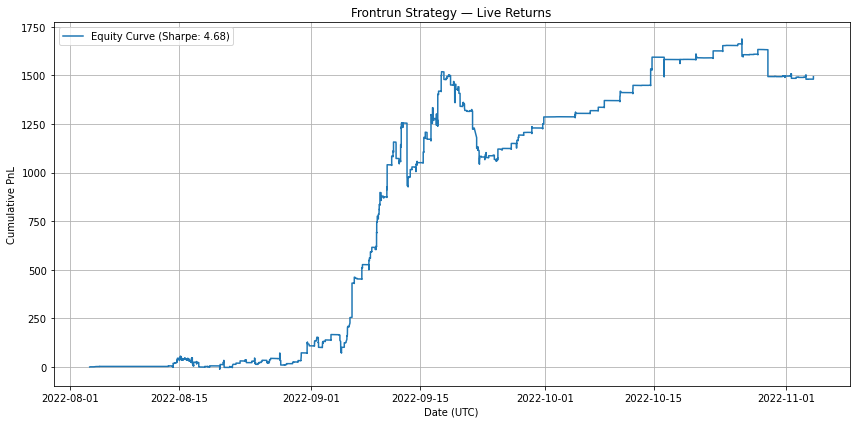

In [3]:
daily = lambda d: d.set_index('Time(UTC)')['net_pnl'].resample('D').sum().loc[lambda x: x != 0]

fp, cap = 'binance_tradehistory.csv', 1000000
df = net(load(fp)); dr = daily(df) / cap
s = np.sqrt(365) * dr.mean() / dr.std(ddof=1) if len(dr) > 1 and dr.std(ddof=1) else np.nan

plt.figure(figsize=(12, 6))
plt.plot(df['Time(UTC)'].to_numpy(), df['cum_pnl'].to_numpy(),
         label=f'Equity Curve (Sharpe: {s:.2f})')
plt.title('Frontrun Strategy — Live Returns')
plt.xlabel('Date (UTC)'); plt.ylabel('Cumulative PnL')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()